In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import numba
import tqdm

import scipy.optimize as opt

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import time
from matplotlib import animation
import math
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay, ConvexHull
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib import cm
import colorcet as cc

In [3]:
def normalize(x, xmin, xmax):
    return (x - xmin) / (xmax - xmin)

def plot_vor_colored(L, x, ax, cmap):
    """
    Plot the Voronoi.

    Takes in a set of cell locs (x), tiles these 9-fold, plots the full voronoi, then crops to the field-of-view

    :param x: Cell locations (nc x 2)
    :param ax: matplotlib axis
    """

#     L = self.L
    grid_x, grid_y = np.mgrid[-1:2, -1:2]
    grid_x[0, 0], grid_x[1, 1] = grid_x[1, 1], grid_x[0, 0]
    grid_y[0, 0], grid_y[1, 1] = grid_y[1, 1], grid_y[0, 0]
    y = np.vstack(
        [
            x + np.array([i * L, j * L])
            for i, j in np.array([grid_x.ravel(), grid_y.ravel()]).T
        ]
    )

    cmap_print = np.tile(cmap.T, 9).T
    bleed = 0.1
    cmap_print = cmap_print[
        (y < L * (1 + bleed)).all(axis=1) + (y > -L * bleed).all(axis=1)
    ]
    y = y[(y < L * (1 + bleed)).all(axis=1) + (y > -L * bleed).all(axis=1)]
    regions, vertices = voronoi_finite_polygons_2d(Voronoi(y))

    ax.set(aspect=1, xlim=(0, L), ylim=(0, L))
    patches = []
    for i, region in enumerate(regions):
        patches.append(
            Polygon(
                vertices[region],
                True,
                facecolor=cmap_print[i],
                edgecolor="white",
                alpha=0.5,
            )
        )

    p = PatchCollection(patches, match_original=True)
    # p.set_array(c_types_print)
    ax.add_collection(p)

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def animate_GRN(
    t_span,
    x_save,
    E_save,
    L,
    file_name=None,
    dir_name="plots",
    n_frames=100,
    fps=15,
    cmap="CET_L8",
    print_updates=True,
):
    """
    Animate the simulation, saving to an mp4 file.

    Parameters
    ----------
    n_frames : int
        Number of frames to animate. Spaced evenly throughout **x_save**

    file_name : str
        Name of the file. If **None** given, generates file-name based on the time of simulation

    dir_name: str
        Directory name to save the plot.


    """
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)

    n_frames = min(n_frames, x_save.shape[0])
    skip = math.floor(x_save.shape[0] / n_frames)

    E_sample = E_save[::skip]
    E_min, E_max = E_sample.min(), E_sample.max()

    def anim(i):
        ax1.cla()
        colors = cc.cm[cmap](normalize(E_sample[i], E_min, E_max))
        plot_vor_colored(L, x_save[skip * i], ax1, colors)
        ax1.set(aspect=1, xlim=(0, L), ylim=(0, L))
        ax1.set_title(f"time = {t_span[skip * i]:.3f}")

    Writer = animation.writers["ffmpeg"]
    writer = Writer(fps=fps, bitrate=1800)
    if file_name is None:
        file_name = "animation_%d" % time.time()
    an = animation.FuncAnimation(fig, anim, frames=n_frames)

    fname = "%s/%s.mp4" % (dir_name, file_name)
    if print_updates:
        print(f"Saving to {fname}")

    an.save(fname, writer=writer, dpi=264)
    plt.close()


In [4]:
# # vor_path = "/home/ubuntu/git/active_vertex"
# vor_path = 'C:\\Users\\Pranav\\git\\active_vertex'

# sys.path.append(vor_path)
# import voronoi_model.voronoi_model_periodic as avm

In [138]:
# Optional/cosmetic 
headtail = np.s_[([*np.arange(5), *(np.arange(5) - 5)])]

# JupyterLab extensions
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


<hr>

In [6]:
@numba.njit
def get_rms(y):
    """Returns root-mean-squared of `y`, a 2D Numpy array
    of displacement (n_samples x n_dim)"""
    # Squared displacement
    sqd = np.sum(y ** 2, axis=1)
    
    # Root-mean of sqd
    return np.sqrt(np.mean(sqd))

In [7]:
@numba.njit
def logistic(x, a, b, N):
    return N/(1 + a * np.exp(-b * x))


@numba.njit
def logistic_norm(x, a, b):
    return 1/(1 + a * np.exp(-b * x))

<hr>

In [8]:
import holoviews as hv

import bokeh_catplot
import bokeh.io
import bokeh.layouts

bokeh.io.output_notebook()
hv.extension("matplotlib")

Loading BokehJS ...

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [10]:
# # Get data 
# data_dir = "C:/Users/Pranav/git/evomorph/2020-09-09_avm_phase_sims_examples/"
# example_files = sorted([os.path.split(f)[-1] for f in glob(data_dir + "*rep?.*", )])

# # Read metadata of all sims in batch
# df = pd.read_csv(os.path.join(data_dir, "metadata_full.csv"), index_col = 0)
# del df["D_eff_n_c"]
# del df["D_eff"]
# df = df.drop_duplicates()
# df = df.loc[np.isin(df["data_fname"], example_files), :].reset_index(drop=True)
# df = df.sort_values("data_fname")

In [47]:
# Get data 
data_dir = "/home/ubuntu/git/evomorph/data/2020-09-09_avm_phase_sims/"
os.chdir(data_dir)

In [53]:
x_files_abspath = sorted([os.path.abspath(p) for p in glob(os.path.join(data_dir, "*.npy"))])
E_files_abspath = sorted([os.path.abspath(p) for p in glob(os.path.join(data_dir, "Esave", "*.npy"))])

In [63]:
# for fx, fE in zip(x_files_abspath, E_files_abspath)
x_files = [os.path.split(f)[-1] for f in x_files_abspath]
E_files = [os.path.join(os.path.split(os.path.split(f)[0])[-1], os.path.split(f)[-1]) for f in E_files_abspath]
files = [*zip(x_files, E_files)]

In [78]:
# Read metadata of all sims in batch
df = pd.read_csv(os.path.join(data_dir, "metadata_full.csv"), index_col = 0)

In [100]:
thresh = 0.1
skip = 20

iterator = range(len(files))
growthmetrics = np.empty((len(files), 3), dtype=np.float32)
iterator = tqdm.tqdm(iterator)

for k in iterator:

    # Extract data and metadata
    x_save = np.load(os.path.join(data_dir, files[k][0]))[::skip]
    E_save = np.load(os.path.join(data_dir, files[k][1]))[::skip]
    metadata = df.loc[df["data_fname"] == xfx,].iloc[0, :].to_dict()

    # Get GRN time-span
    t_span = np.linspace(metadata["t0"], metadata["tmax"], metadata["n_t"])[::skip]

    # Get additional params
    L = metadata["L"]
    n_t, n_c = E_save.shape

    #Apply threshold and calculate proportion of population
    E_thresh = E_save > thresh
    E_thresh_prop = np.sum(E_thresh, axis=1) / n_c
    
    rmss = np.empty(n_t)
    chull_vols = np.empty(n_t)
    for i, X in enumerate(x_save):
        
        # Catch if too few cells above threshold (n_thresh)
        n_thresh = sum(E_thresh[i])
        if n_thresh == 0:
            rmss[i] = 0
            chull_vols[i] = 0
        elif n_thresh < 3:
            chull_vols[i] = 0
        else:
            X = X - L/2
            d = X[E_thresh[i].nonzero()[0], :]
            rmss[i] = get_rms(d)
            chull_vols[i] = ConvexHull(d).volume
    
    num_gr = opt.curve_fit(
        logistic_norm, 
        t_span, 
        E_thresh_prop,
        bounds=((0, 0), (np.inf, np.inf)),
    )[0][1]
    rms_gr = opt.curve_fit(
        logistic, 
        t_span, 
        rmss,
        bounds=((0, 0, 0,), (np.inf, np.inf, L*np.sqrt(2))),
    )[0][1]
    chull_gr = opt.curve_fit(
        logistic,
        t_span,
        chull_vols,
        bounds=((0, 0, 0,), (np.inf, np.inf, L**2,)),
    )[0][1]
    
    growthmetrics[k] = (num_gr, rms_gr, chull_gr)
    

100%|██████████| 264/264 [03:42<00:00,  1.19it/s]


In [118]:
# Save growth metrics to DataFrame
gr_df = (
    pd.DataFrame(
        dict(zip(files, growthmetrics)),
        index=[
            "growth rate of # cells",
            "growth rate of RMS distance",
            "growth rate of CHull area",
        ],
    )
    .reset_index()
    .melt(id_vars="index")
)

# Make tidy
gr_df.columns = ["metric", "data_fname", "Esave_fname", "value"]
gr_df = gr_df.sort_values(["data_fname", "metric"])
gr_df = gr_df[["data_fname", "Esave_fname", "metric", "value"]]

In [120]:
df = df.merge(gr_df)

In [121]:
df["_v0"] = [f"{s:.3f}" for s in df.v0]

In [147]:
df.iloc[headtail]

,data_fname,p0,v0,replicate,f,t0,tmax,dt,n_t,a,k,J,L,Esave_fname,metric,value,_v0
0,p03.50_v06.00e-03_rep0.npy,3.5,0.006,0,200,0,4,0.025,32001,0.4,2,0.0,10,Esave/p03.50_v06.00e-03_rep0_Esave.npy,growth rate of # cells,2.411053,0.006
1,p03.50_v06.00e-03_rep0.npy,3.5,0.006,0,200,0,4,0.025,32001,0.4,2,0.0,10,Esave/p03.50_v06.00e-03_rep0_Esave.npy,growth rate of CHull area,2.308652,0.006
2,p03.50_v06.00e-03_rep0.npy,3.5,0.006,0,200,0,4,0.025,32001,0.4,2,0.0,10,Esave/p03.50_v06.00e-03_rep0_Esave.npy,growth rate of RMS distance,1.693878,0.006
3,p03.50_v01.00e-02_rep0.npy,3.5,0.010,0,200,0,4,0.025,32001,0.4,2,0.0,10,Esave/p03.50_v01.00e-02_rep0_Esave.npy,growth rate of # cells,2.411020,0.010
4,p03.50_v01.00e-02_rep0.npy,3.5,0.010,0,200,0,4,0.025,32001,0.4,2,0.0,10,Esave/p03.50_v01.00e-02_rep0_Esave.npy,growth rate of CHull area,2.423790,0.010
787,p03.90_v02.60e-02_rep2.npy,3.9,0.026,2,200,0,4,0.025,32001,0.4,2,0.0,10,Esave/p03.90_v02.60e-02_rep2_Esave.npy,growth rate of CHull area,4.020757,0.026
788,p03.90_v02.60e-02_rep2.npy,3.9,0.026,2,200,0,4,0.025,32001,0.4,2,0.0,10,Esave/p03.90_v02.60e-02_rep2_Esave.npy,growth rate of RMS distance,2.635839,0.026
789,p03.90_v03.00e-02_rep2.npy,3.9,0.030,2,200,0,4,0.025,32001,0.4,2,0.0,10,Esave/p03.90_v03.00e-02_rep2_Esave.npy,growth rate of # cells,3.916090,0.030
790,p03.90_v03.00e-02_rep2.npy,3.9,0.030,2,200,0,4,0.025,32001,0.4,2,0.0,10,Esave/p03.90_v03.00e-02_rep2_Esave.npy,growth rate of CHull area,4.934699,0.030
791,p03.90_v03.00e-02_rep2.npy,3.9,0.030,2,200,0,4,0.025,32001,0.4,2,0.0,10,Esave/p03.90_v03.00e-02_rep2_Esave.npy,growth rate of RMS distance,2.859207,0.030


In [139]:
df.to_csv(os.path.join(data_dir, "metadata_full_growthrate.csv"))

<hr>

In [152]:
grouped = df.groupby(["p0", "v0", "metric"]).mean()["value"].reset_index()
grouped.iloc[headtail]

,p0,v0,metric,value
0,3.5,0.002,growth rate of # cells,2.411145
1,3.5,0.002,growth rate of CHull area,2.468133
2,3.5,0.002,growth rate of RMS distance,1.683428
3,3.5,0.006,growth rate of # cells,2.410957
4,3.5,0.006,growth rate of CHull area,2.416968
259,3.9,0.026,growth rate of CHull area,3.995700
260,3.9,0.026,growth rate of RMS distance,2.484603
261,3.9,0.030,growth rate of # cells,4.290029
262,3.9,0.030,growth rate of CHull area,5.169235
263,3.9,0.030,growth rate of RMS distance,2.902478


:NdLayout   [metric]
   :Points   [p0,v0]   (metric,value)
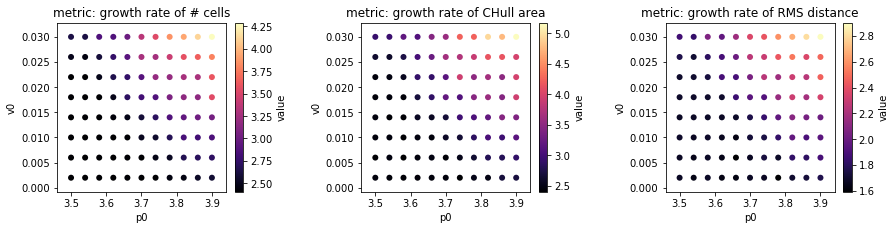

In [164]:
plt = hv.Points(
    data=grouped,
    kdims=["p0", "v0"],
    vdims=["metric", "value"],
).groupby(
    "metric"
).opts(
    color="value",
    cmap="magma",
    axiswise=True,
    colorbar=True,
# ).redim.range(
#     **{"value":(1.5, 6.0)}
).layout().cols(3)

plt.opts(hspace=0.8)

In [180]:
p0_vals = np.unique(grouped["p0"])
v0_vals = np.unique(grouped["v0"])
p0_vals

array([3.5 , 3.54, 3.58, 3.62, 3.66, 3.7 , 3.74, 3.78, 3.82, 3.86, 3.9 ])

:NdLayout   [metric]
   :Scatter   [v0]   (value,metric)
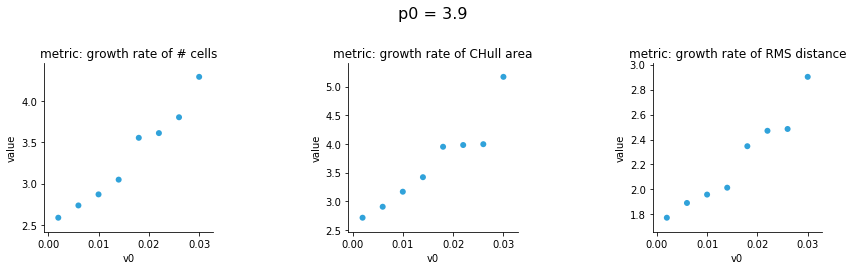

In [171]:
p0_val = 3.9
plt = hv.Scatter(
    data=grouped.loc[grouped["p0"] == p0_val],
    kdims=["v0"],
    vdims=["value", "metric", ],
).groupby(
    "metric"
).opts(
#     color="value",
#     cmap="magma",
    axiswise=True,
#     colorbar=True,
# ).redim.range(
#     **{"value":(1.5, 6.0)}
).layout().cols(3)

plt.opts(hspace=0.8).opts(title=f"p0 = {p0_val}")

:NdLayout   [metric]
   :Scatter   [v0]   (value,metric)
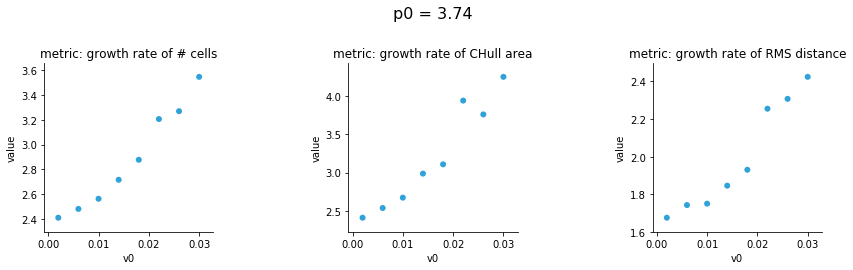

In [179]:
p0_val = p0_vals[6]
plt = hv.Scatter(
    data=grouped.loc[grouped["p0"] == p0_val],
    kdims=["v0"],
    vdims=["value", "metric", ],
).groupby(
    "metric"
).opts(
#     color="value",
#     cmap="magma",
    axiswise=True,
#     colorbar=True,
# ).redim.range(
#     **{"value":(1.5, 6.0)}
).layout().cols(3)

plt.opts(hspace=0.8).opts(title=f"p0 = {p0_val}")

In [306]:
pp, vv = grouped["p0"].values[::3], grouped["v0"].values[::3]
gr_ncell, gr_rmsd, gr_chull = grouped["value"].values.reshape(-1, 3).T

:TriSurface   [p0,v0,value]
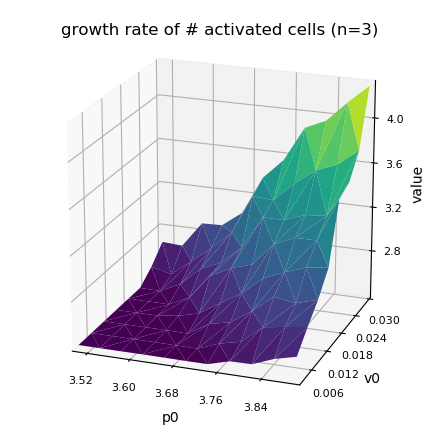

In [320]:
plt = hv.TriSurface(
    data=(pp, vv, gr_ncell),
    kdims=["p0", "v0", "value"],
).opts(
    title="growth rate of # activated cells (n=3)",
    azimuth=-70,
    elevation=20,
    fig_size=150,
    padding=0,
    fontscale=1,
    xticks=5, 
    yticks=5,
    zticks=5,
    fontsize=dict(ticks=8),
)

hv.output(plt, dpi=100)

:TriSurface   [p0,v0,value]
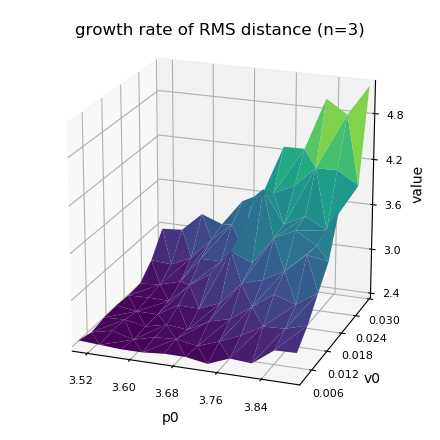

In [321]:
plt = hv.TriSurface(
    data=(pp, vv, gr_rmsd),
    kdims=["p0", "v0", "value"],
).opts(
    title="growth rate of RMS distance (n=3)",
    azimuth=-70,
    elevation=20,
    fig_size=150,
    padding=0,
    fontscale=1,
    xticks=5, 
    yticks=5,
    zticks=5,
    fontsize=dict(ticks=8),
)

hv.output(plt, dpi=100)

:TriSurface   [p0,v0,value]
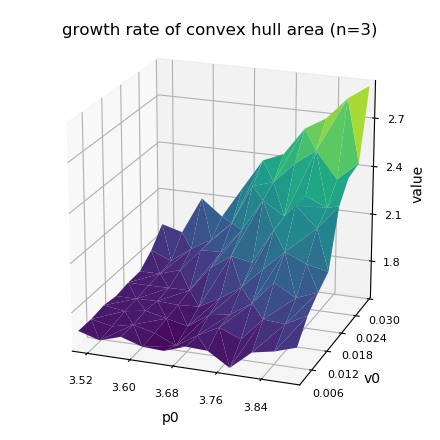

In [322]:
plt = hv.TriSurface(
    data=(pp, vv, gr_chull),
    kdims=["p0", "v0", "value"],
).opts(
    title="growth rate of convex hull area (n=3)",
    azimuth=-70,
    elevation=20,
    fig_size=150,
    padding=0,
    fontscale=1,
    xticks=5, 
    yticks=5,
    zticks=5,
    fontsize=dict(ticks=8),
)

hv.output(plt, dpi=100)

:NdOverlay   [metric]
   :Curve   [v0]   (value,metric)
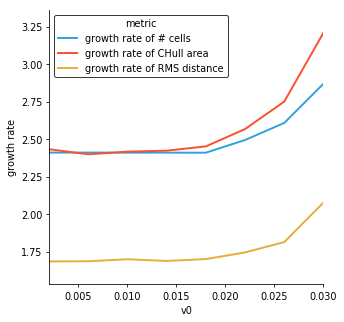

In [353]:
p0_val = p0_vals[2]
plt = hv.Curve(
    data=grouped.loc[grouped["p0"] == p0_val, :],
    kdims=["v0"],
    vdims=["value", "metric"],
).groupby(
    "metric"
).opts(
#     color="value",
#     cmap="magma",
#     axiswise=True,
#     colorbar=True,
#     show_legend=False,
#     fontscale=1.3,
    ylabel="growth rate",
    fig_size=140,
# ).redim.range(
#     **{"value":(1.5, 6.0)}
).overlay("metric")

hv.output(plt, dpi=70)

:NdLayout   [p0]
   :NdOverlay   [metric]
      :Curve   [v0]   (value,metric,p0)
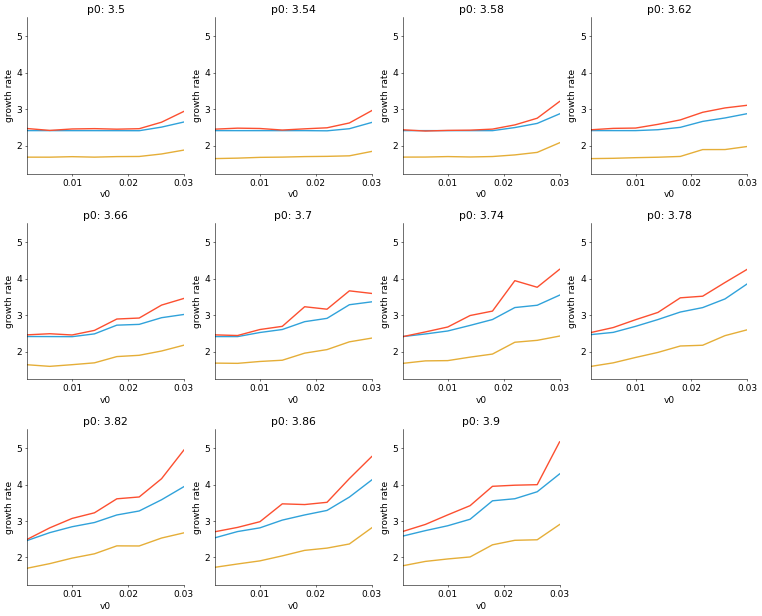

In [342]:
p0_val = p0_vals[0]
plt = hv.Curve(
    data=grouped,
    kdims=["v0"],
    vdims=["value", "metric", "p0"],
).groupby(
    ["metric", "p0"]
).opts(
#     color="value",
#     cmap="magma",
#     axiswise=True,
#     colorbar=True,
    show_legend=False,
    fontscale=1.3,
    ylabel="growth rate",
# ).redim.range(
#     **{"value":(1.5, 6.0)}
).overlay("metric").layout("p0")

hv.output(plt.opts(hspace=0.2).cols(4), dpi=50)

:NdLayout   [v0]
   :NdOverlay   [metric]
      :Curve   [p0]   (value,metric,v0)
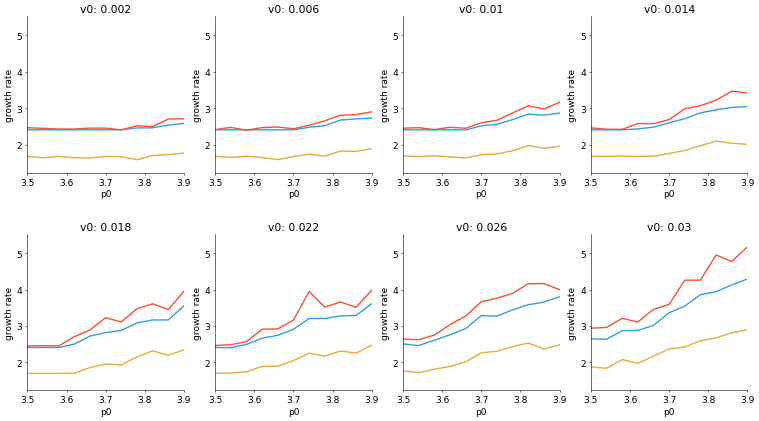

In [355]:
p0_val = p0_vals[0]
plt = hv.Curve(
    data=grouped,
    kdims=["p0"],
    vdims=["value", "metric", "v0"],
).groupby(
    ["metric", "v0"]
).opts(
#     color="value",
#     cmap="magma",
#     axiswise=True,
#     colorbar=True,
    show_legend=False,
    fontscale=1.3,
    ylabel="growth rate",
# ).redim.range(
#     **{"value":(1.5, 6.0)}
).overlay("metric").layout("v0")

hv.output(plt.opts(hspace=0.2).cols(4), dpi=50)

In [178]:
plt1 = bokeh_catplot.strip(
    data=df,
    cats=["p0", "_v0"],
    val="cells growth rate",
    width=500
)
plt2 = bokeh_catplot.strip(
    data=df,
    cats=["p0", "_v0"],
    val="RMSD growth rate",
    width=500
)
plt3 = bokeh_catplot.strip(
    data=df,
    cats=["p0", "_v0"],
    val="CHull growth rate",
    width=500
)

bokeh.io.show(bokeh.layouts.gridplot((plt1, plt2, plt3), ncols=1))

In [77]:
# Extract parameter spaces
p_space = np.unique(df.p0.values)
v_space = np.unique(df.v0.values)
rep_space = np.unique(df.replicate.values)

In [49]:
# # Extract data and metadata
# f = example_files[0]
# x_save = np.load(os.path.join(data_dir, f))
# E_save = np.load(os.path.join(data_dir, f[:-4] + "_Esave.npy"))
# x = x_save[0]

In [ ]:
#     # Animate
#     animate_GRN(
#         t_span,
#         x_save,
#         E_save,
#         L,
#         file_name=f[:-4],
#         n_frames=100, 
#         cmap="kgy", 
#         print_updates=True
#     )

In [212]:
v_vals = np.array([np.float(pre[11:19]) for pre in prefixes])

In [213]:
num_growth = np.array(num_growth)

In [214]:
data = pd.DataFrame({
    "Mean cell speed": v_vals, 
    "RMS growth": rms_growth, 
    "activated cells growth": num_growth,
    "convex hull growth": chull_growth
})

data = data.melt(id_vars=["Mean cell speed"])
data.columns = ["Mean cell speed", "area method", "growth rate"]

:NdOverlay   [area method]
   :Scatter   [Mean cell speed]   (growth rate,area method)
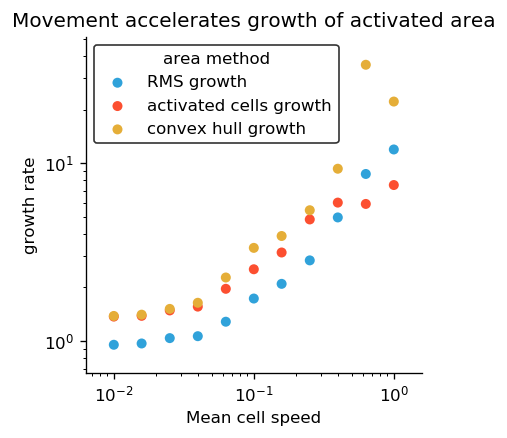

In [217]:
plt = hv.Scatter(
    data = data,
    kdims = ["Mean cell speed"],
    vdims = ["growth rate", "area method"],
).groupby(
    "area method"
).opts(
    logx=True,
    logy=True,
    title="Movement accelerates growth of activated area"
).overlay()

hv.output(plt, dpi=120)